In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [2]:
run_qs = RunStats.objects.filter(psearch__id=83, method="BD", status=3)

pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'))

,K,alpha,coherence,exclusivity,max_iter,rng_seed,run_id,top_chain_var
0,20,0.01,0.400404,0.523049,50,1,2154,0.010
1,45,0.05,0.514492,0.775650,50,1,2137,0.005
2,45,0.01,0.493715,0.846099,50,1,2145,0.010
3,45,0.05,0.370210,0.701541,50,1,2122,0.100
4,45,0.10,0.506084,0.780998,50,1,2121,0.005
5,45,0.10,0.491302,0.871996,50,1,2120,0.010
6,50,0.01,0.496631,0.781455,50,1,2112,0.005
7,45,0.10,0.416262,0.824821,50,1,2119,0.050
8,45,0.01,0.508955,0.742253,50,1,2111,0.005
9,45,0.05,0.480421,0.870453,50,1,2136,0.010


In [3]:
run_id = 2155
# for ISIE talk: run_id = 1749

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
# total score of DocTopics, sorted by topic
pd.DataFrame.from_dict(list(dts.values('topic__id', 'topic__title').annotate(
    totalscore = Sum('score')
).order_by('-totalscore')))

{'n': 3934749.1500025}


,topic__id,topic__title,totalscore
0,178515,stop words,619234.291928
1,178481,procedural 1,273809.686006
2,178498,economic policy 1,202963.147750
3,178513,procedural 2,142553.991272
4,178495,europe,141410.998528
5,178489,procedural 3,120756.670825
6,178497,general policy statements,116614.982983
7,178478,German-French coal plan,115945.235466
8,178484,budget,110642.907628
9,178472,green opposition,101886.271129


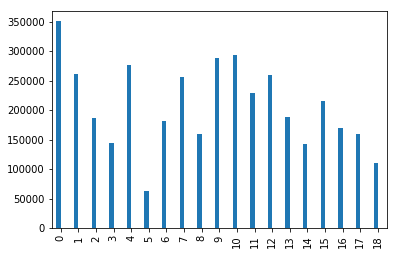

In [4]:
dts_list = list(dts.values('ut__document__parlperiod__n').annotate(
    n = Sum('score')
))
df_dts_list = pd.DataFrame(dts_list)
df_dts_list.columns = ['DocTopic_score', 'parlperiod']
df_dts_list.set_index('parlperiod')
df_dts_list.plot(kind='bar', legend=False)

In [5]:
stat = RunStats.objects.get(run_id=run_id)
search = stat.psearch
uts = pm.Utterance.objects.filter(search_matches=search)
print(uts.count())

period_counts = uts.values('document__parlperiod__n').annotate(n=Count('document__parlperiod__n'))
party_counts = uts.values('speaker__party__name').annotate(n=Count('speaker__party__name'))

9167


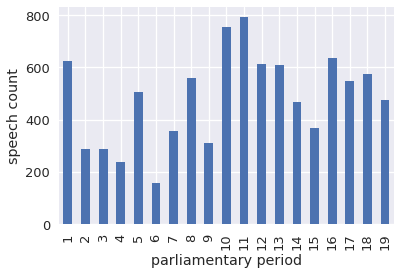

In [6]:
# plot parliamentary period counts
sns.set()
sns.set_context("talk")
df_period_counts = pd.DataFrame.from_dict(period_counts)
df_period_counts = df_period_counts.set_index('document__parlperiod__n')
df_period_counts.plot(kind='bar', legend=False)
plt.xlabel('parliamentary period')
plt.ylabel('speech count')
fig = plt.gcf()
fig.savefig(os.path.join(save_dir, 'parlperiod_speech_count_search_{}.png'.format(search.id)), dpi=300,  bbox_inches="tight")

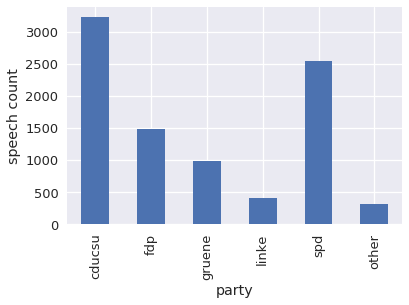

In [9]:
# plot party counts
df_party_counts = pd.DataFrame.from_dict(party_counts)
df_party_counts = df_party_counts.set_index('speaker__party__name')

# drop some of the labels:
#df_party_counts = df_party_counts.drop(["fraktionslos", "parteilos", "pds", None])
# or summarize them:
other_labels = ["bp", "dp", "drp", "dzp", "fraktionslos", "gb/bhe", "other", "parteilos", "pds", "wav", "afd", "kpd", None]
df_party_counts.loc["other"] = df_party_counts.loc[other_labels].sum()
df_party_counts = df_party_counts.loc[["cducsu", "fdp", "gruene", "linke", "spd", "other"]]

df_party_counts.plot(kind='bar', legend=False)
plt.xlabel('party')
plt.ylabel('speech count')
fig = plt.gcf()
fig.savefig(os.path.join(save_dir, 'party_speech_count_search_{}.png'.format(search.id)), dpi=300,  bbox_inches="tight")

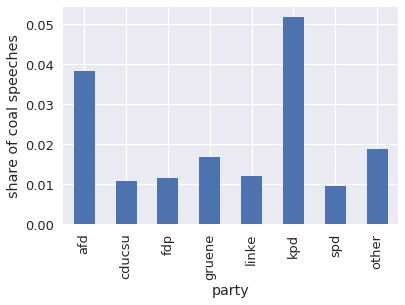

In [82]:
# party shares
party_counts = uts.values('speaker__party__name').annotate(n=Count('speaker__party__name'))
party_counts_all = pm.Utterance.objects.all().values('speaker__party__name').annotate(n_tot=Count('speaker__party__name'))


df_party_counts = pd.DataFrame.from_dict(party_counts)
df_party_counts = df_party_counts.set_index('speaker__party__name')

df_party_counts_all = pd.DataFrame.from_dict(party_counts_all)
df_party_counts_all = df_party_counts_all.set_index('speaker__party__name')

df_pc = df_party_counts.join(df_party_counts_all)

# drop some of the labels:
#df_pc = df_pc.drop(["fraktionslos", "parteilos", "pds", "afd", None])
# or summarize them:
df_pc.loc["other"] = df_pc.loc[["bp", "dp", "drp", "dzp", "fraktionslos", "gb/bhe", "other", "parteilos", "pds", "wav", None]].sum()
df_pc = df_pc.loc[["afd", "cducsu", "fdp", "gruene", "linke", "kpd", "spd", "other"]]

df_pc['share'] = df_pc['n'] / df_pc['n_tot']

df_pc.plot(kind='bar', y="share", legend=False)
plt.xlabel('party')
plt.ylabel('share of coal speeches')
fig = plt.gcf()
fig.savefig(os.path.join(save_dir,'party_share_search_{}.png'.format(search.id)), dpi=300,  bbox_inches="tight")